In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit

from pysim import SimBoostRegressor, SimBoostClassifier

## Regression

In [2]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])

beta = np.vstack([beta1, beta2, beta3])
model_list = [lambda x: 0.2 * np.exp(-4 * x), lambda x: 3 * x ** 2, lambda x: 2.5 * np.sin(1.5 * np.pi * x)]

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(20000, 10), random_state=random_state)
noise = np.random.randn(20000).reshape(-1, 1)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + noise
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [3]:
%%time 

middle_update = {"method":"bfgs",
                 "tol":0.0001,
                 "max_middle_iter":3,
                 "n_middle_iter_no_change":3, 
                 "max_inner_iter":20,
                 "learning_rate":1e-3,
                 "stratify":True,
                 "verbose":False}
        
clf = SimBoostRegressor(n_estimators=20, knot_num=10, knot_dist="uniform", spline="smoothing_spline_mgcv", learning_rate=1,
                        reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5], reg_gamma="GCV", degree=3, pruning=False, early_stop_thres=1,
                        middle_update=middle_update, meta_info=None)
clf.fit(train_x, train_y)

CPU times: user 41min 25s, sys: 1h 24min 9s, total: 2h 5min 35s
Wall time: 10min 5s


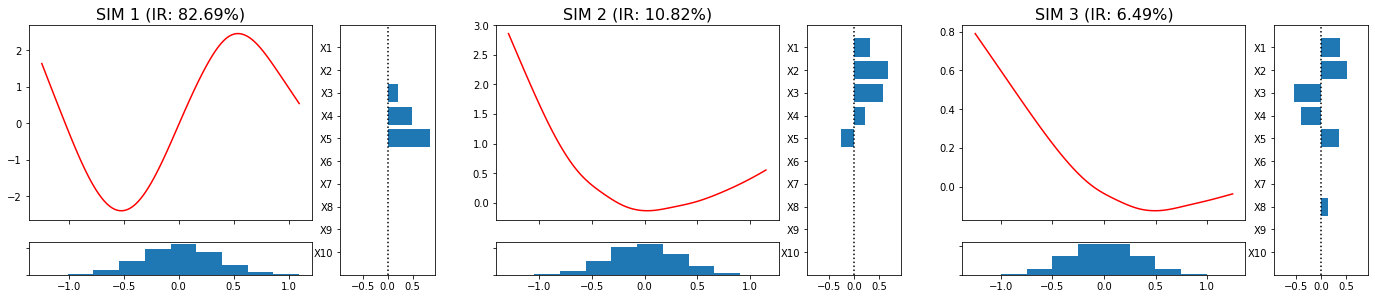

In [4]:
clf.visualize()

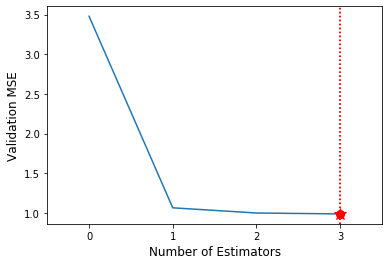

In [5]:
clf.validation_performance()

In [6]:
mean_squared_error(test_y, clf.predict(test_x))

1.023820866355395

## LogitBoost

In [7]:
random_state = 0
np.random.seed(random_state)
# data generation
beta1 = np.array([.2, 0.3, 0.5, 0, 0, 0, 0, 0, 0, 0])
beta2 = np.array([0, .2, 0.3, 0.5, 0, 0, 0, 0, 0, 0])
beta3 = np.array([0, 0, 0.2, 0.3, 0.5, 0, 0, 0, 0, 0])
beta = np.vstack([beta1, beta2, beta3])

x = truncnorm.rvs(a=-3, b=3, loc = 0, scale=1 / 3, size=(10000, 10), random_state=random_state)
y = np.reshape(0.2 * np.exp(-4 * np.dot(x, beta1)) + \
               3 * (np.dot(x, beta2)) ** 2 + 2.5 * np.sin(np.pi * 1.5 * np.dot(x, beta3)), [-1, 1]) + \
    np.random.randn(10000).reshape(-1, 1)
y[y <= 0] = 0
y[y > 0] = 1
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

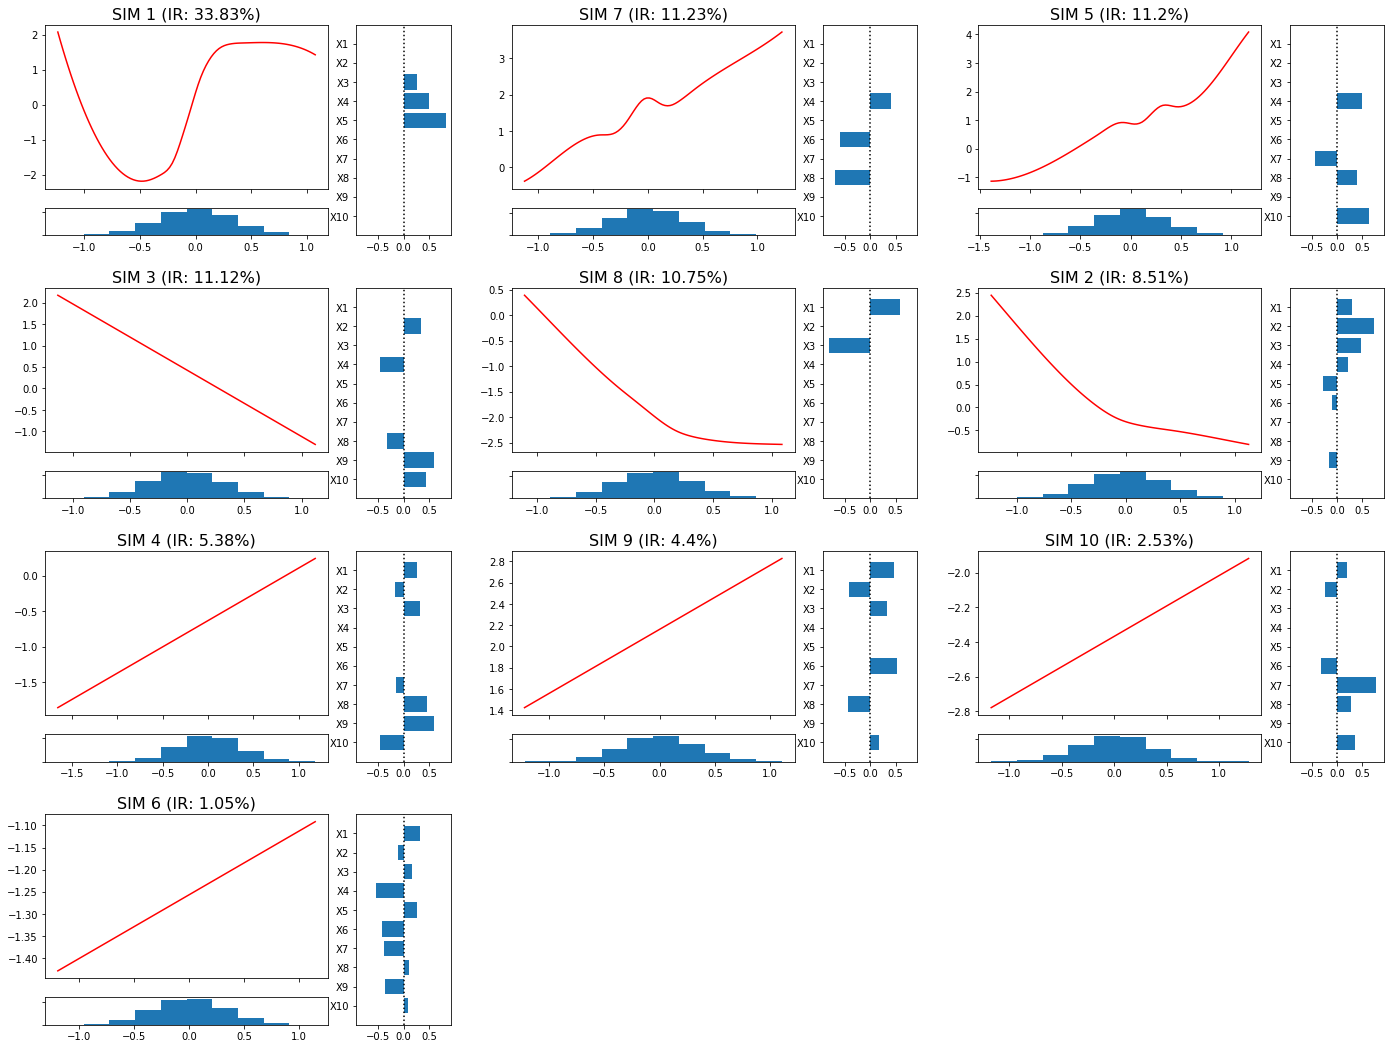

CPU times: user 2h 8min 16s, sys: 4h 50min 13s, total: 6h 58min 29s
Wall time: 18min 8s


In [8]:
%%time 

middle_update = {"method":"bfgs",
                 "tol":0.0001,
                 "max_middle_iter":3,
                 "n_middle_iter_no_change":3, 
                 "max_inner_iter":20,
                 "learning_rate":1e-3,
                 "stratify":True,
                 "verbose":False}

clf = SimBoostClassifier(n_estimators=10, knot_num=10, knot_dist="quantile", spline="smoothing_spline_mgcv", learning_rate=1,
                         reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5], reg_gamma="GCV", degree=3, 
                         middle_update=middle_update, pruning=False, meta_info=None)
clf.fit(train_x, train_y)
clf.visualize()

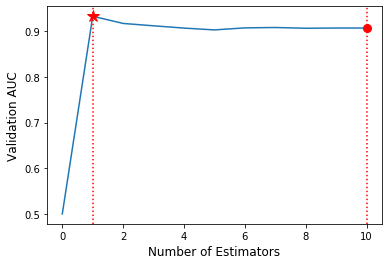

In [9]:
clf.validation_performance()

In [10]:
roc_auc_score(test_y, clf.predict_proba(test_x)[:, 1])

0.8967505257024144